In [271]:
import torch as tc 
from torch import nn, optim 
from torch.utils.data import TensorDataset, DataLoader, random_split, ConcatDataset

from torchmetrics import Accuracy 

from torchvision import datasets
from torchvision import transforms as T
from torchvision.datasets import MNIST
from torchvision.utils import make_grid, save_image

import numpy as np 
import pandas  as pd 
import matplotlib.pyplot as plt 

from tqdm import tqdm 

import cv2

In [272]:
z_dim = 64

In [273]:
device = 'cuda' if tc.cuda.is_available() else 'cpu'

In [274]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [275]:
train_dataset = MNIST('datasets', download = True, train = True, transform = T.ToTensor())

In [276]:
valid_dataset = MNIST('/home/ahmadrezabaqerzadeh/datasets/', train = False, download = True, transform = T.ToTensor())

In [277]:
dataset = ConcatDataset([train_dataset, valid_dataset])

In [278]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: datasets
    Split: Train
    StandardTransform
Transform: ToTensor()

In [279]:
valid_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: /home/ahmadrezabaqerzadeh/datasets/
    Split: Test
    StandardTransform
Transform: ToTensor()

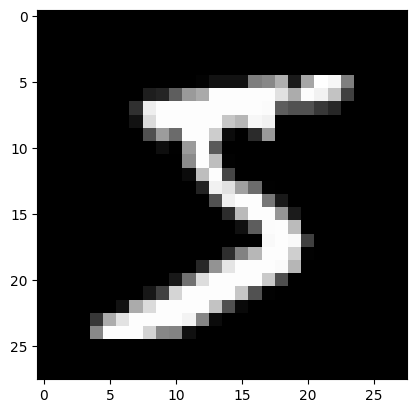

In [280]:
plt.imshow(dataset[0][0].squeeze(0), cmap = 'gray')

In [281]:
dataset[0][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [282]:
train_loader = DataLoader(dataset, batch_size = 64, shuffle = True)

In [283]:
x, y = next(iter(train_loader))

In [284]:
x.shape

torch.Size([64, 1, 28, 28])

In [285]:
y.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [286]:
xmk = make_grid(x, 8)

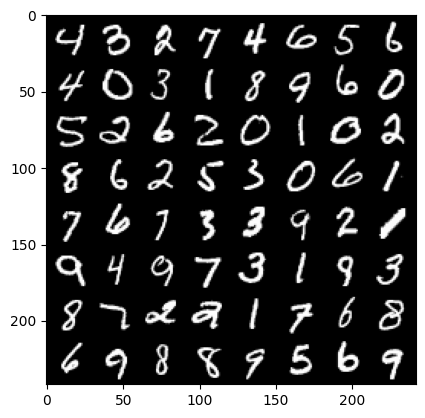

In [287]:
plt.imshow(xmk.permute(1, 2, 0), cmap = 'gray')

In [288]:
class Generator(nn.Module):
    
    def __init__(self, dim):
        super(Generator, self).__init__()
        
        #self.layers = nn.ModuleList()
        #for i in range(num_layers):
         #   self.layers.append(nn.LazyLinear((i+1) * neuron))
            
        self.fc1 = nn.LazyLinear(256)
        self.fc2 = nn.LazyLinear(512)
        self.fc3 = nn.LazyLinear(1024)
        self.fc4 = nn.LazyLinear(dim * dim)
            
    def forward(self, z):
        
        z = nn.LeakyReLU(0.2)(self.fc1(z))
        z = nn.LeakyReLU(0.2)(self.fc2(z))
        z = nn.LeakyReLU(0.2)(self.fc3(z))
        y = nn.Tanh()(self.fc4(z))
        
        return y

In [289]:
G_model = Generator(28).to(device)

/home/ahmadrezabaqerzadeh/.local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [290]:
G_model(tc.randn(64, 100).to(device)).shape

torch.Size([64, 784])

In [291]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.fc1 = nn.LazyLinear(1024)
        self.fc2 = nn.LazyLinear(512)
        self.fc3 = nn.LazyLinear(256)
        self.fc4 = nn.LazyLinear(1)
        
    def forward(self, x):
        
        x = nn.Dropout(0.3)(nn.LeakyReLU(0.2)(self.fc1(x)))
        x = nn.Dropout(0.3)(nn.LeakyReLU(0.2)(self.fc2(x)))
        x = nn.Dropout(0.3)(nn.LeakyReLU(0.2)(self.fc3(x)))
        y = nn.Sigmoid()(self.fc4(x))
        
        return y

In [292]:
D_model = Discriminator().to(device)

In [293]:
D_model

Discriminator(
  (fc1): LazyLinear(in_features=0, out_features=1024, bias=True)
  (fc2): LazyLinear(in_features=0, out_features=512, bias=True)
  (fc3): LazyLinear(in_features=0, out_features=256, bias=True)
  (fc4): LazyLinear(in_features=0, out_features=1, bias=True)
)

In [294]:
yp = D_model(x.flatten(1).to(device))

In [295]:
D_model = Discriminator().to(device)
G_model = Generator(28).to(device)

In [296]:
loss_func = nn.BCELoss()
optimizer_D = optim.Adam(D_model.parameters(), lr = 0.0002, betas = [0.9, 0.99])
optimizer_G = optim.Adam(G_model.parameters(), lr = 0.0002, betas = [0.9, 0.99])

In [297]:
def train_one_epoch(D_model, G_model, data_loader, loss_func, optimizer_d, optimizer_g, epoch):
    D_model.train()
    G_model.train()
    
    pass

In [298]:
for epoch in range(200):
    for x, y  in train_loader:
        #Discriminator
        D_model.zero_grad()
        #for k in range(5):
        x_real = x.flatten(1).to(device)
        y_real = tc.ones(y.shape[0], 1).to(device)
       
        D_out = D_model(x_real)
        loss_D = loss_func(D_out, y_real)
        
        z = tc.randn(x.shape[0], z_dim).to(device)
        y_fake = tc.zeros(x.shape[0], 1).to(device)
        
        #D(G(z))
        x_fake = G_model(z).to(device)
        G_out = D_model(x_fake).to(device)
    
        loss_G = loss_func(G_out, y_fake)
        
        total_loss = loss_D + loss_G
        
        total_loss.backward()
        optimizer_D.step()
        
        #Generator
        G_model.zero_grad()
        
        #optimizer_G.zero_grad()
        z = tc.randn(x.shape[0], z_dim).to(device)
        y_real = tc.ones(x.shape[0], 1).to(device)
        
        out = D_model(G_model(z))
        loss_G = loss_func(out, y_real)
        
        loss_G.backward()
        optimizer_G.step()
    print(f'epoch={epoch}, dis loss={total_loss}, gen loss={loss_G}')

epoch=0, dis loss=0.7616097331047058, gen loss=4.932794094085693
epoch=1, dis loss=0.3054746687412262, gen loss=3.1594395637512207
epoch=2, dis loss=1.1197302341461182, gen loss=1.7253141403198242
epoch=3, dis loss=0.7389892339706421, gen loss=2.001433849334717
epoch=4, dis loss=0.6947104334831238, gen loss=2.0416409969329834
epoch=5, dis loss=0.6130973100662231, gen loss=1.7553775310516357
epoch=6, dis loss=1.1316338777542114, gen loss=1.6872667074203491
epoch=7, dis loss=0.9315571784973145, gen loss=1.7868613004684448
epoch=8, dis loss=0.7472521066665649, gen loss=2.0890307426452637
epoch=9, dis loss=0.9637126326560974, gen loss=1.8294048309326172
epoch=10, dis loss=0.9076820611953735, gen loss=1.6611374616622925
epoch=11, dis loss=0.6179500818252563, gen loss=2.3245348930358887
epoch=12, dis loss=0.9245117902755737, gen loss=1.7722944021224976
epoch=13, dis loss=0.8291377425193787, gen loss=2.394953966140747
epoch=14, dis loss=0.47720956802368164, gen loss=2.218000888824463
epoch=15

In [367]:
yp = G_model(tc.randn(1, 64).to(device))

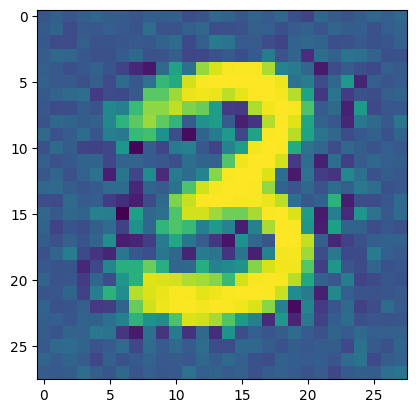

In [368]:
plt.imshow(yp.reshape(28, 28).cpu().detach())